In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
import keras
from keras.datasets import mnist
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [4]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 253032141.95it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 105795365.79it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 78638824.23it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20331407.44it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [5]:
# We take only data without labels, because in this case we dont need them.
(X_train,_),(X_test,_) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


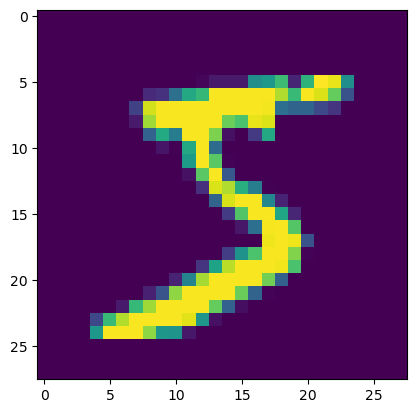

In [6]:
plt.imshow(X_train[0])

In [26]:
X_train[0].shape

(28, 28)

In [9]:
num_workers=0
batch_size=32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

---


(1, 28, 28)     (28, 28)


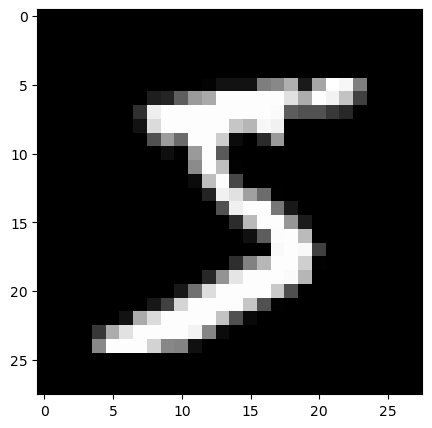

In [42]:
### Visualize data from DataLoader

# obtain one batch of training images
dataiter = iter(train_loader)
images,_= next(dataiter)
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0]) # (1, 28, 28) -> (28,28)
print(images[0].shape,"   ", np.squeeze(images[0]).shape)

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---

In [11]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder,self).__init__()
        ## Encoder Layers ##
        self.conv1 = nn.Conv2d(1,16,3,padding='same')
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(16,32,3,padding='same')
        self.conv3 = nn.Conv2d(32,64,3,padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(64,32,3,padding='same')
        self.conv5 = nn.Conv2d(32,16,3,padding='same')
        
        ## Decoder Layers ##
        self.t_conv1 = nn.ConvTranspose2d(16,32,2,stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32,64,4,stride=1)
        self.t_conv3 = nn.ConvTranspose2d(64,32,4,stride=1)
        self.t_conv4 = nn.ConvTranspose2d(32,32,5,stride=1)
        self.t_conv5 = nn.ConvTranspose2d(32,16,3,stride=1)
        self.t_conv6 = nn.ConvTranspose2d(16,16,2,stride=1)
        self.t_conv7 = nn.ConvTranspose2d(16,1,2,stride=1)
        
    def forward(self,x):
        
        ## encode ##
        x = F.elu(self.conv1(x))
        x = self.pool1(x)
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = self.pool2(x)
        x = F.elu(self.conv4(x))
        x = F.elu(self.conv5(x))
        
        ## decode ##
        x = F.elu(self.t_conv1(x))
        x = F.elu(self.t_conv2(x))
        x = F.elu(self.t_conv3(x))
        x = F.elu(self.t_conv4(x))
        x = F.elu(self.t_conv5(x))
        x = F.elu(self.t_conv6(x))
        x = F.sigmoid(self.t_conv7(x))
        
        return x
    
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (t_conv1): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (t_conv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(1, 1))
  (t_conv4): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (t_conv5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (t_conv6): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(1, 1))
  (t_

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [13]:
n_epochs = 15

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    for data in train_loader:
        # no need to flatten images
        images,_ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 0.545963
Epoch: 2 	Training Loss: 0.175532
Epoch: 3 	Training Loss: 0.120186
Epoch: 4 	Training Loss: 0.093576
Epoch: 5 	Training Loss: 0.077783
Epoch: 6 	Training Loss: 0.068031
Epoch: 7 	Training Loss: 0.061252
Epoch: 8 	Training Loss: 0.055542
Epoch: 9 	Training Loss: 0.051324
Epoch: 10 	Training Loss: 0.047409
Epoch: 11 	Training Loss: 0.044950
Epoch: 12 	Training Loss: 0.042568
Epoch: 13 	Training Loss: 0.040539
Epoch: 14 	Training Loss: 0.039011
Epoch: 15 	Training Loss: 0.037796


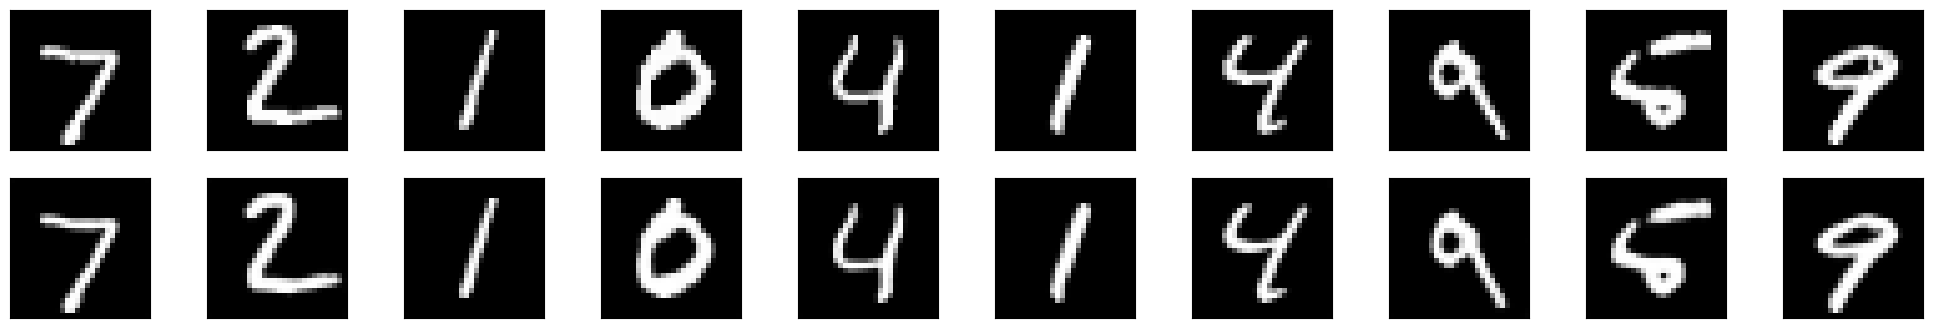

In [14]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)